## Installing Libraries

In [0]:
!pip install -q torchvision

## Importing Libraries

In [0]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Data Loading Class

In [0]:
class FashionMNIST(Dataset):
  
  def __init__(self, csv_file, transform = None):
    data = pd.read_csv(csv_file)
    self.X = np.array(data.iloc[:, 1:]).reshape(-1,1,28,28)
    self.Y = np.array(data.iloc[:,0])
    del data
    self.transform = transform
    
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,index):
    item = self.X[index]
    label = self.Y[index]

## Hyperparameters

In [0]:
BATCH_SIZE = 100
EPOCHS = 25
LEARNING_RATE = 0.001

## DATA Transformation

In [0]:
transform = transforms.ToTensor()

train_set = torchvision.datasets.FashionMNIST('/f-mnist',train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.FashionMNIST('f-mnist', train=False, download= True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

## Class Labels

In [0]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

## Sample Datapoints

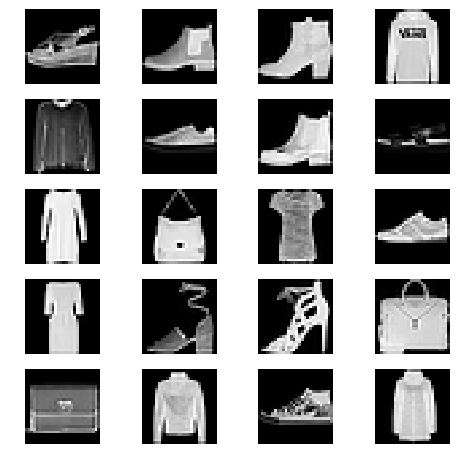

In [7]:
fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
  img_xy = np.random.randint(len(train_set))
  img = train_set[img_xy][0][0,:,:]
  fig.add_subplot(rows,columns,i)
  #plt.title(labels_map[train_set[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utility Function

In [0]:
def show_batch(batch):
  im = torchvision.utils.make_grid(batch)
  plt.imshow(np.transpose(im.numpy(), (1,2,0)))

## Complete Batch

Labels:  tensor([5, 1, 6, 2, 0, 2, 0, 6, 9, 7, 1, 8, 2, 0, 3, 0, 9, 3, 3, 4, 8, 7, 5, 4,
        4, 1, 9, 1, 1, 5, 5, 2, 4, 3, 4, 1, 4, 4, 7, 7, 3, 6, 4, 5, 8, 7, 7, 0,
        8, 8, 1, 6, 2, 8, 1, 6, 8, 0, 4, 6, 1, 7, 2, 7, 9, 7, 2, 8, 5, 6, 4, 9,
        4, 4, 5, 4, 9, 6, 9, 4, 9, 4, 7, 4, 2, 4, 6, 0, 1, 5, 0, 2, 3, 2, 2, 0,
        7, 7, 8, 3])
Batch shape:  torch.Size([100, 1, 28, 28])


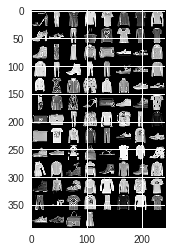

In [12]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

In [13]:
images.view(BATCH_SIZE, -1).size()

torch.Size([100, 784])

## CNN Class

In [0]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Maxpool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected 1
        self.fc1 = nn.Linear(32*4*4, 10)
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Maxpool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Maxpool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        # Linear function (readout)
        out = self.fc1(out)
        
        return out

## Initiating Classifier

In [0]:
cnn = CNN()

In [19]:
cnn

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

## Loss Function & Optimizer

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
optimizer = opt.Adam(cnn.parameters(), lr=LEARNING_RATE)

## Training Classifier

In [33]:
iter = 0
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images)
        labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = cnn(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images)
                
                # Forward pass only to get logits/output
                outputs = cnn(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
           # print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))
            print('Iteration : ', iter,' Accuracy : ',accuracy)

Iteration :  500  Accuracy :  tensor(86)
Iteration :  1000  Accuracy :  tensor(86)
Iteration :  1500  Accuracy :  tensor(86)
Iteration :  2000  Accuracy :  tensor(86)
Iteration :  2500  Accuracy :  tensor(87)
Iteration :  3000  Accuracy :  tensor(87)
Iteration :  3500  Accuracy :  tensor(87)
Iteration :  4000  Accuracy :  tensor(87)
Iteration :  4500  Accuracy :  tensor(87)
Iteration :  5000  Accuracy :  tensor(86)
Iteration :  5500  Accuracy :  tensor(87)
Iteration :  6000  Accuracy :  tensor(87)
Iteration :  6500  Accuracy :  tensor(87)
Iteration :  7000  Accuracy :  tensor(87)
Iteration :  7500  Accuracy :  tensor(87)
Iteration :  8000  Accuracy :  tensor(88)
Iteration :  8500  Accuracy :  tensor(87)
Iteration :  9000  Accuracy :  tensor(88)
Iteration :  9500  Accuracy :  tensor(87)
Iteration :  10000  Accuracy :  tensor(88)
Iteration :  10500  Accuracy :  tensor(88)
Iteration :  11000  Accuracy :  tensor(88)
Iteration :  11500  Accuracy :  tensor(88)
Iteration :  12000  Accuracy : 

## Evaluating our Classifier on the Test Set

In [0]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
  images = Variable(images.float())
  outputs = cnn(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum()

In [35]:
print('Test Accuracy of the model on 10000 test images : %.4f %%' % (100 *correct / total))

Test Accuracy of the model on 10000 test images : 90.0000 %
